<a href="https://colab.research.google.com/github/Sultan-al-islam/audio-codec/blob/main/Thisis_prectice_BanglaAudio_Data_Set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import numpy as np
import soundfile as sf
from torch.utils.data import DataLoader, Dataset
from google.colab import drive

In [ ]:
# 1. SETUP & DATA LOADING
# -------------------------------------------------------------------
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Path to your BBC audio files in Drive

AUDIO_FOLDER = '/content/drive/MyDrive/Bangla_3sec_audio/processed_3sec'
SAVE_PATH = '/content/drive/MyDrive/AudioSavepath'

In [ ]:
class BBCDataset(Dataset):
    def __init__(self, folder_path, segment_length=1024):
        self.segment_length = segment_length
        self.data = []

        print("Preprocessing audio files into mono 44.1kHz...")
        files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

        for file in files:
            file_path = os.path.join(folder_path, file)
            # Load and Normalize
            audio, _ = librosa.load(file_path, sr=44100, mono=True)
            if np.max(np.abs(audio)) > 0:
                audio = audio / np.max(np.abs(audio)) # Normalization for stability

            for i in range(0, len(audio) - segment_length, segment_length):
                self.data.append(audio[i : i + segment_length])

        self.data = np.array(self.data)
        print(f"Total audio segments prepared: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.data[idx])

In [ ]:
# 2. UPDATED VAE ARCHITECTURE
# -------------------------------------------------------------------
class AudioVAE(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=512, latent_dim=64):
        super(AudioVAE, self).__init__()

        # Encoder: Using LeakyReLU to prevent dead neurons
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2)
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh() # Audio output range -1 to 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # MSE with 'mean' reduction makes loss values easier to monitor
    MSE = nn.functional.mse_loss(recon_x, x, reduction='mean')

    # KL Divergence
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Beta-VAE approach: weight the KLD to prevent it from dominating
    return MSE + 0.001 * KLD

In [ ]:
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = BBCDataset(AUDIO_FOLDER)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

    model = AudioVAE().to(device)
    # Lower learning rate for better convergence
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    print("Starting Training (30 Epochs)...")
    for epoch in range(30):
        model.train()
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()

            recon, mu, logvar = model(batch)
            loss = vae_loss(recon, batch, mu, logvar)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} Complete. Avg Loss: {avg_loss:.8f}")

    return model, dataset

# Run the training
trained_model, bbc_dataset = train()

Preprocessing audio files into mono 44.1kHz...
Total audio segments prepared: 562440
Starting Training (30 Epochs)...
Epoch 1 Complete. Avg Loss: 0.01148879
Epoch 2 Complete. Avg Loss: 0.00669000
Epoch 3 Complete. Avg Loss: 0.00577155
Epoch 4 Complete. Avg Loss: 0.00529873
Epoch 5 Complete. Avg Loss: 0.00513379
Epoch 6 Complete. Avg Loss: 0.00499849
Epoch 7 Complete. Avg Loss: 0.00490490
Epoch 8 Complete. Avg Loss: 0.00483557
Epoch 9 Complete. Avg Loss: 0.00475691
Epoch 10 Complete. Avg Loss: 0.00468338
Epoch 11 Complete. Avg Loss: 0.00460709
Epoch 12 Complete. Avg Loss: 0.00456433
Epoch 13 Complete. Avg Loss: 0.00453505
Epoch 14 Complete. Avg Loss: 0.00450275
Epoch 15 Complete. Avg Loss: 0.00446668
Epoch 16 Complete. Avg Loss: 0.00443745
Epoch 17 Complete. Avg Loss: 0.00441795
Epoch 18 Complete. Avg Loss: 0.00440226
Epoch 19 Complete. Avg Loss: 0.00438301
Epoch 20 Complete. Avg Loss: 0.00436290
Epoch 21 Complete. Avg Loss: 0.00434544
Epoch 22 Complete. Avg Loss: 0.00433099
Epoch 23 Co

In [ ]:
# 5. RECONSTRUCTION & EXPORT
# -------------------------------------------------------------------
trained_model.eval()
with torch.no_grad():
    # Take a sample segment and reconstruct it
    sample = bbc_dataset[0].unsqueeze(0).to(next(trained_model.parameters()).device)
    reconstructed, _, _ = trained_model(sample)

    # Export to check audio fidelity [cite: 204]
    output_audio = reconstructed.cpu().numpy().flatten()
    sf.write(SAVE_PATH + '.wav', output_audio, 44100)
    print(f"Reconstructed audio saved at {SAVE_PATH}. Compare this to original for quality check.")

Reconstructed audio saved at /content/drive/MyDrive/AudioSavepath. Compare this to original for quality check.


In [ ]:
def calculate_metrics(original, reconstructed):
    # Mean Square Error (MSE) [cite: 129]
    mse = np.mean((original - reconstructed) ** 2)

    # Signal-to-Noise Ratio (SNR) [cite: 205]
    signal_power = np.mean(original ** 2)
    noise_power = mse
    snr = 10 * np.log10(signal_power / noise_power)

    return mse, snr


original_sample = bbc_dataset[0].numpy()
reconstructed_sample = output_audio

mse, snr = calculate_metrics(original_sample, reconstructed_sample)
print(f"Mean Square Error (MSE): {mse:.6f}")
print(f"Signal to Noise Ratio (SNR): {snr:.2f} dB")

Mean Square Error (MSE): 0.001970
Signal to Noise Ratio (SNR): 13.57 dB


In [ ]:
def calculate_accuracy_score(original, reconstructed):
    # Calculate cosine similarity as an 'accuracy' measure
    # A value of 1 means perfect similarity, -1 means perfect dissimilarity.
    # We'll scale it to a 0-1 range for an 'accuracy score'.

    # Handle cases where original or reconstructed audio is a zero vector
    # This prevents division by zero in norm calculation
    if np.linalg.norm(original) == 0 or np.linalg.norm(reconstructed) == 0:
        return 0.0 # Or some other appropriate value for zero-length/silent audio

    cosine_sim = np.dot(original, reconstructed) / (np.linalg.norm(original) * np.linalg.norm(reconstructed))

    # Scale cosine similarity from [-1, 1] to [0, 1] to represent accuracy
    # 0.5 would be no correlation, 1 perfect correlation, 0 perfect anti-correlation
    accuracy_score = (cosine_sim + 1) / 2
    return accuracy_score

In [ ]:
accuracy = calculate_accuracy_score(original_sample, reconstructed_sample)
print(f"Accuracy Score (Cosine Similarity): {accuracy:.4f}")

Accuracy Score (Cosine Similarity): 0.9890


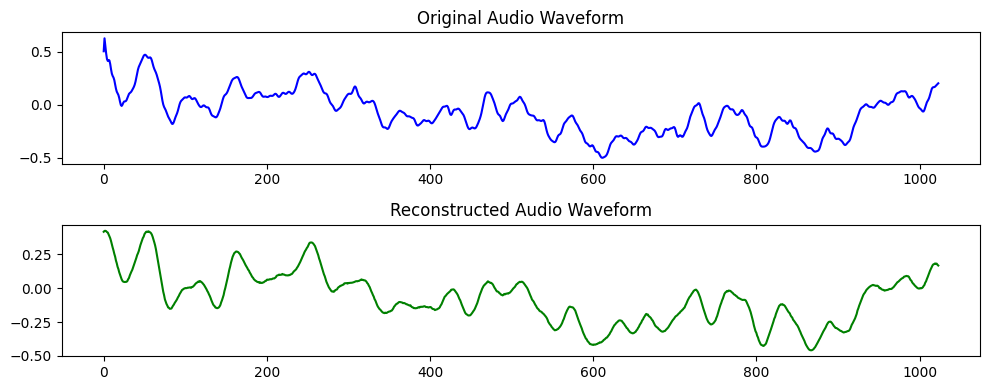

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(original_sample, color='blue')
plt.title("Original Audio Waveform")

plt.subplot(2, 1, 2)
plt.plot(reconstructed_sample, color='green')
plt.title("Reconstructed Audio Waveform")

plt.tight_layout()
plt.show()

In [ ]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# ১. স্পেকট্রোগ্রাম এবং মেল-স্পেকট্রোগ্রাম তুলনা (Research Visualization)
def visualize_audio_analysis(original, reconstructed, sr=44100):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # --- অরিজিনাল অডিওর লিনিয়ার স্পেকট্রোগ্রাম ---
    D_orig = librosa.amplitude_to_db(np.abs(librosa.stft(original)), ref=np.max)
    img1 = librosa.display.specshow(D_orig, sr=sr, x_axis='time', y_axis='linear', ax=axes[0, 0])
    axes[0, 0].set_title('Original Linear Spectrogram')
    fig.colorbar(img1, ax=axes[0, 0], format="%+2.f dB")

    # --- রিকনস্ট্রাক্ট করা অডিওর লিনিয়ার স্পেকট্রোগ্রাম ---
    D_recon = librosa.amplitude_to_db(np.abs(librosa.stft(reconstructed)), ref=np.max)
    img2 = librosa.display.specshow(D_recon, sr=sr, x_axis='time', y_axis='linear', ax=axes[0, 1])
    axes[0, 1].set_title('Reconstructed Linear Spectrogram')
    fig.colorbar(img2, ax=axes[0, 1], format="%+2.f dB")

    # --- অরিজিনাল অডিওর মেল-স্পেকট্রোগ্রাম (Human Hearing Scale) ---
    S_orig = librosa.feature.melspectrogram(y=original, sr=sr, n_mels=128)
    S_orig_db = librosa.power_to_db(S_orig, ref=np.max)
    img3 = librosa.display.specshow(S_orig_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[1, 0])
    axes[1, 0].set_title('Original Mel-Spectrogram')
    fig.colorbar(img3, ax=axes[1, 0], format="%+2.f dB")

    # --- রিকনস্ট্রাক্ট করা অডিওর মেল-স্পেকট্রোগ্রাম ---
    S_recon = librosa.feature.melspectrogram(y=reconstructed, sr=sr, n_mels=128)
    S_recon_db = librosa.power_to_db(S_recon, ref=np.max)
    img4 = librosa.display.specshow(S_recon_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[1, 1])
    axes[1, 1].set_title('Reconstructed Mel-Spectrogram')
    fig.colorbar(img4, ax=axes[1, 1], format="%+2.f dB")

    plt.suptitle(f"Detailed Audio Reconstruction Analysis (SNR: {snr:.2f} dB)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
def plot_distribution(original, reconstructed):
    plt.figure(figsize=(10, 4))
    plt.hist(original, bins=100, alpha=0.5, label='Original Data Distribution', color='blue')
    plt.hist(reconstructed, bins=100, alpha=0.5, label='Reconstructed Data Distribution', color='green')
    plt.title("Audio Sample Value Distribution")
    plt.xlabel("Amplitude Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


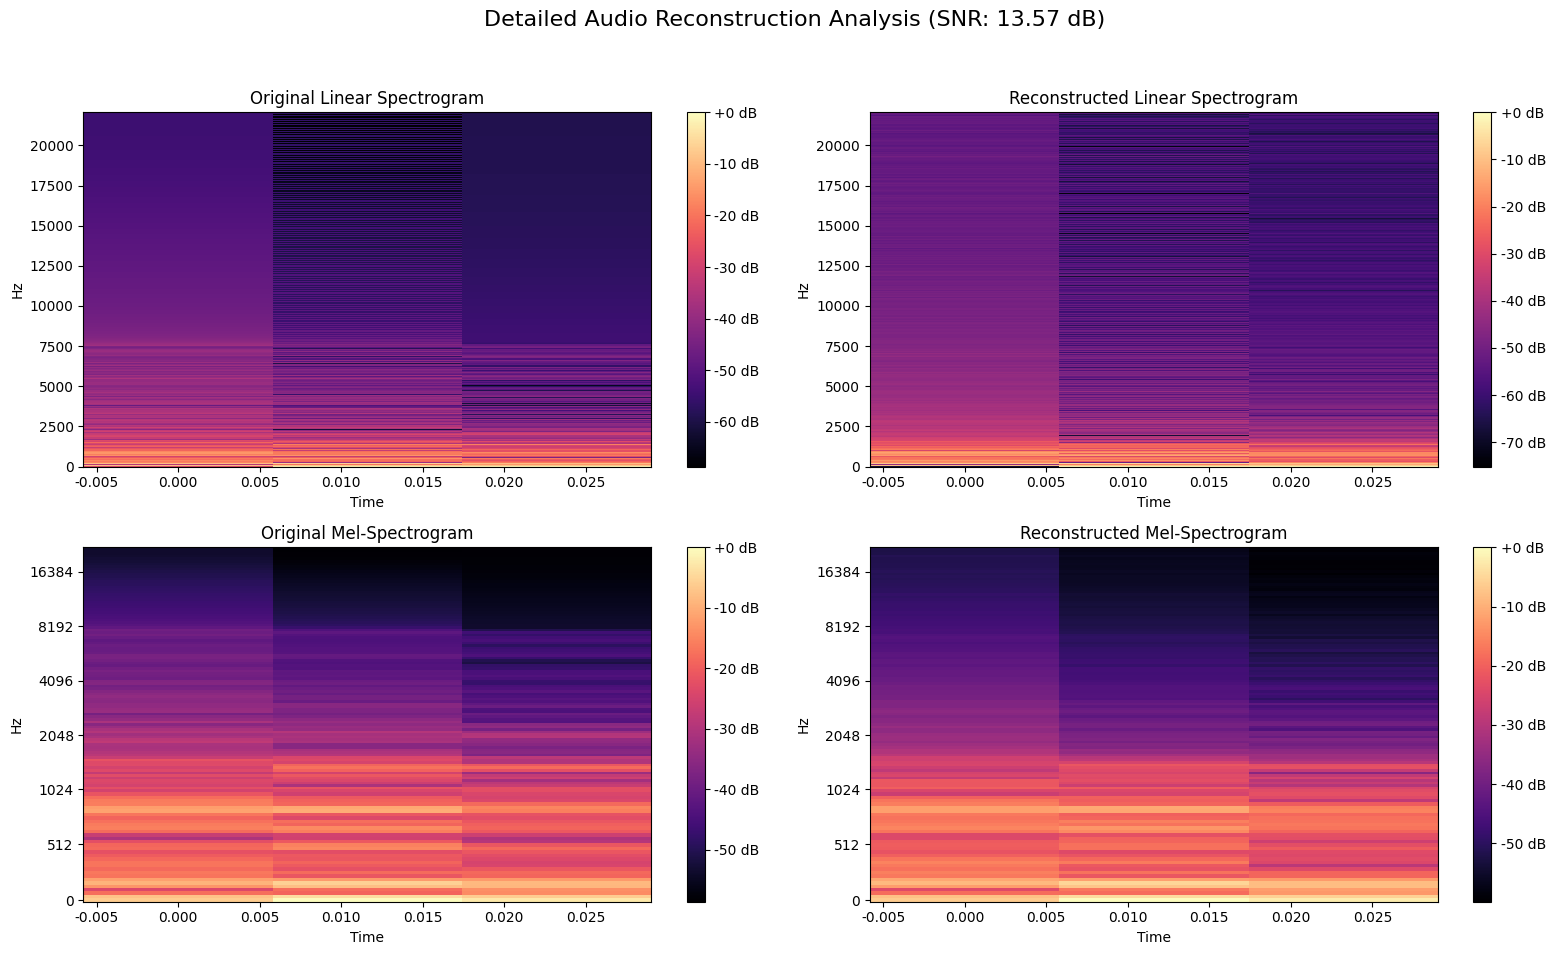

NameError: name 'plot_distribution' is not defined

In [ ]:
# ফাংশনগুলো রান করা
visualize_audio_analysis(original_sample, reconstructed_sample)
plot_distribution(original_sample, reconstructed_sample)